In [1]:
#!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings            
warnings.filterwarnings("ignore")

In [3]:
# Download TSLA Data (10 years)
df = yf.download('TSLA', start='2014-01-01', end='2024-12-31')
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2014-01-02,10.006667,10.165333,9.770000,9.986667,92826000
2014-01-03,9.970667,10.146000,9.906667,10.000000,70425000
2014-01-06,9.800000,10.026667,9.682667,10.000000,80416500
2014-01-07,9.957333,10.026667,9.683333,9.841333,75511500
2014-01-08,10.085333,10.246667,9.917333,9.923333,92448000


In [5]:
df.shape

(2767, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2767 entries, 2014-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   2767 non-null   float64
 1   (High, TSLA)    2767 non-null   float64
 2   (Low, TSLA)     2767 non-null   float64
 3   (Open, TSLA)    2767 non-null   float64
 4   (Volume, TSLA)  2767 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 129.7 KB


In [7]:
# Step 2: Feature engineering
def add_indicators(data):
    data['MACD'] = data['Close'].ewm(span=12).mean() - data['Close'].ewm(span=26).mean()
    data['Signal_Line'] = data['MACD'].ewm(span=9).mean()

    delta = data['Close'].diff()
    gain = delta.copy()
    loss = delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    loss = loss.abs()
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    sma = data['Close'].rolling(window=20).mean()
    std = data['Close'].rolling(window=20).std()
    data['Upper_BB'] = sma + 2 * std
    data['Lower_BB'] = sma - 2 * std

    data['Momentum'] = data['Close'] - data['Close'].shift(10)

    low_min = data['Low'].rolling(window=14).min()
    high_max = data['High'].rolling(window=14).max()
    data['Stochastic'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))

    data['Volume_Change'] = data['Volume'].pct_change() * 100

    return data.dropna()

In [8]:
df = add_indicators(df)

In [9]:
# Step 3: Label next-day movement
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [10]:
# Drop NA values after indicators
df.dropna(inplace=True)

In [11]:
# Step 4: Feature selection
features = ['MACD', 'Signal_Line', 'RSI', 'Upper_BB', 'Lower_BB', 'Momentum', 'Stochastic', 'Volume_Change']
X = df[features]
y = df['Target']

In [12]:
# 5. Train/Test Split (chronological split to avoid leakage)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [13]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Balance the training data
sm = SMOTE(random_state=42)
X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)

In [15]:
#  Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [16]:
rf_preds = rf.predict(X_test_scaled)

In [17]:
print("Random Forest Performance:\n", classification_report(y_test, rf_preds))

Random Forest Performance:
               precision    recall  f1-score   support

           0       0.47      0.30      0.37       267
           1       0.51      0.67      0.58       283

    accuracy                           0.49       550
   macro avg       0.49      0.49      0.47       550
weighted avg       0.49      0.49      0.48       550



In [18]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [19]:
xgb_preds = xgb.predict(X_test_scaled)

In [20]:
print("XGBoost Performance:\n", classification_report(y_test, xgb_preds))

XGBoost Performance:
               precision    recall  f1-score   support

           0       0.49      0.38      0.43       267
           1       0.52      0.63      0.57       283

    accuracy                           0.51       550
   macro avg       0.51      0.51      0.50       550
weighted avg       0.51      0.51      0.50       550



In [21]:
# LSTM Model
def reshape_lstm(x):
    return x.reshape((x.shape[0], 1, x.shape[1]))

In [22]:
X_train_lstm = reshape_lstm(X_train_scaled)
X_test_lstm = reshape_lstm(X_test_scaled)

In [23]:
lstm = Sequential()
lstm.add(LSTM(50, return_sequences=False, input_shape=(1, X_train_lstm.shape[2])))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,851 (46.29 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
lstm.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5292 - loss: 0.6933
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4898 - loss: 0.6930
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5297 - loss: 0.6922
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5047 - loss: 0.6927
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4960 - loss: 0.6943
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5033 - loss: 0.6924
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5054 - loss: 0.6926
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5147 - loss: 0.6906
Epoch 9/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5245 - loss: 0.6904
Epoch 10/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5112 - loss: 0.6909


In [27]:
lstm_preds = (lstm.predict(X_test_lstm) > 0.5).astype("int32")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [28]:
print("LSTM Performance:\n", classification_report(y_test, lstm_preds))

LSTM Performance:
               precision    recall  f1-score   support

           0       0.50      0.42      0.45       267
           1       0.52      0.61      0.56       283

    accuracy                           0.51       550
   macro avg       0.51      0.51      0.51       550
weighted avg       0.51      0.51      0.51       550



<Figure size 1400x600 with 0 Axes>

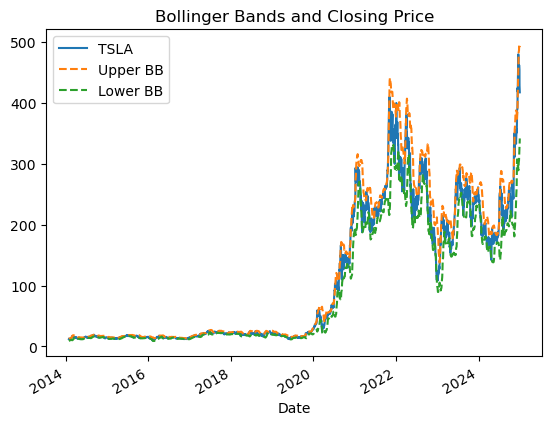

In [29]:
# Plot Sample Indicators
plt.figure(figsize=(14, 6))
df['Close'].plot(label='Close')
df['Upper_BB'].plot(label='Upper BB', linestyle='--')
df['Lower_BB'].plot(label='Lower BB', linestyle='--')
plt.legend()
plt.title("Bollinger Bands and Closing Price")
plt.show()

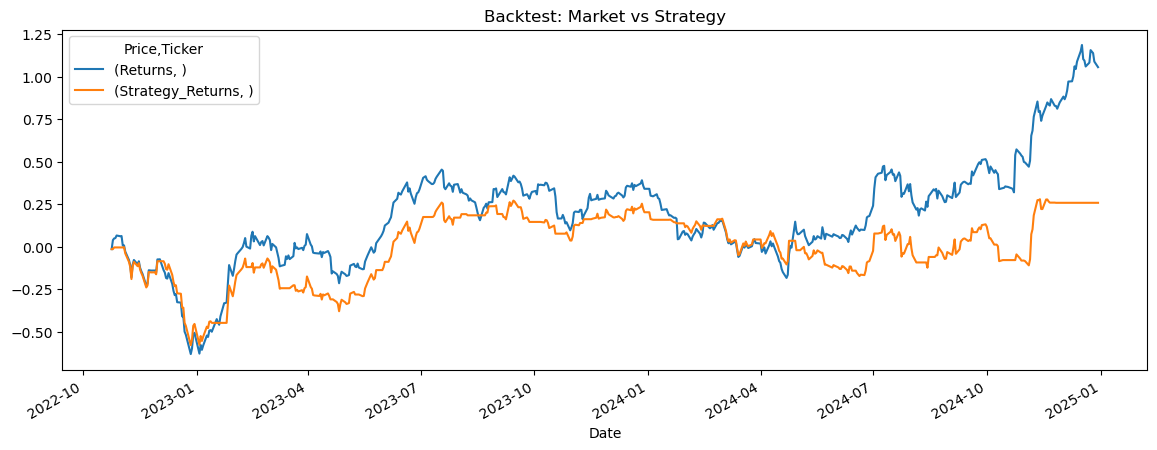

In [30]:
# Backtesting Strategy (basic simulation)
df_test = df.iloc[train_size:].copy()
df_test['Pred_RF'] = rf_preds
df_test['Returns'] = df_test['Close'].pct_change()
df_test['Strategy_Returns'] = df_test['Returns'] * df_test['Pred_RF'].shift(1)
df_test[['Returns', 'Strategy_Returns']].cumsum().plot(figsize=(14,5), title='Backtest: Market vs Strategy')
plt.show()